In [ ]:
# Extra Dataset: Data Collection & Preprocessing  
**Objective:** Found a better dataset to make this more challenging, clean & vectorize for use in `02_Sentiment_Analysis.ipynb`.


Shape: (138873, 8)
Columns: ['reviewId', 'userName', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'appVersion']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138873 entries, 0 to 138872
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              138873 non-null  object
 1   userName              138871 non-null  object
 2   content               138867 non-null  object
 3   score                 138873 non-null  int64 
 4   thumbsUpCount         138873 non-null  int64 
 5   reviewCreatedVersion  115229 non-null  object
 6   at                    138873 non-null  object
 7   appVersion            115229 non-null  object
dtypes: int64(2), object(6)
memory usage: 8.5+ MB

Missing values per column:
reviewId                    0
userName                    2
content                     6
score                       0
thumbsUpCount               0
reviewCreat

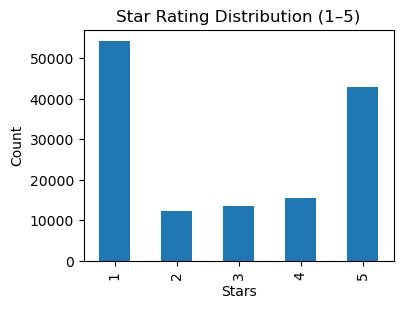


Review length (chars):
count    138873.000000
mean        144.972709
std         115.922211
min           2.000000
25%          69.000000
50%         115.000000
75%         185.000000
max        1752.000000
Name: content_len, dtype: float64


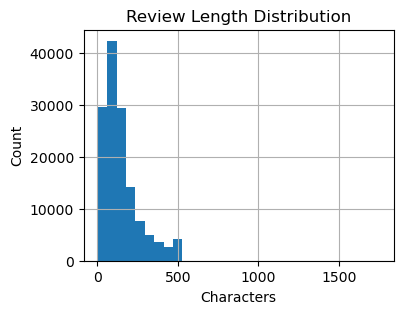


Thumbs-Up Count summary:
count    138873.000000
mean          8.746524
std          92.612080
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        8032.000000
Name: thumbsUpCount, dtype: float64

Sample Negative Reviews (score <= 2):


5566     Please add an option to select the quality you...
12352    Prices going up AGAIN. The Disney+, Hulu, Max ...
10271                                              Rubbish
Name: content, dtype: object


Sample Positive Reviews (score >= 4):


75975     Very very good but bengali movies and sreies s...
57776     Good but wish they had new content and now con...
102597    this app is good but it need more showes, and ...
Name: content, dtype: object

In [30]:
# %% Full Exploratory EDA for netflix_reviews.csv
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load
df = pd.read_csv('../data/netflix_reviews.csv', encoding='latin-1')

# 2. Shape & columns
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# 3. Info & missingness
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum())

# 4. Score distribution
plt.figure(figsize=(4,3))
df['score'].value_counts().sort_index().plot(kind='bar')
plt.title("Star Rating Distribution (1–5)")
plt.xlabel("Stars"); plt.ylabel("Count")
plt.show()

# 5. Review‐length stats & histogram
df['content_len'] = df['content'].astype(str).str.len()
print("\nReview length (chars):")
print(df['content_len'].describe())
plt.figure(figsize=(4,3))
df['content_len'].hist(bins=30)
plt.title("Review Length Distribution")
plt.xlabel("Characters"); plt.ylabel("Count")
plt.show()

# 6. Thumbs‐Up count summary
print("\nThumbs-Up Count summary:")
print(df['thumbsUpCount'].describe())

# 7. Sample texts by score
print("\nSample Negative Reviews (score <= 2):")
display(df[df['score']<=2]['content'].sample(3, random_state=1))
print("\nSample Positive Reviews (score >= 4):")
display(df[df['score']>=4]['content'].sample(3, random_state=1))







In [31]:
# %% Map score → sentiment and rename text column
df = df.rename(columns={'content':'review_text', 'score':'stars'})

# 1–2 → negative, 3 → neutral, 4–5 → positive
df['sentiment'] = df['stars'].map(lambda s: 
    'negative' if s <= 2 else 'neutral' if s == 3 else 'positive'
)

# Quick check
print(df['sentiment'].value_counts())
display(df[['review_text','stars','sentiment']].head())


sentiment
negative    66667
positive    58622
neutral     13584
Name: count, dtype: int64


,review_text,stars,sentiment
0,great,5,positive
1,fraud,1,negative
2,iam irritated by the new Household network whi...,1,negative
3,how can a major company not be able to change ...,1,negative
4,Great app ð,5,positive


In [32]:
# %% Clean text into `cleaned_review`
import re
from nltk.corpus       import stopwords
from nltk.stem         import WordNetLemmatizer

stop_words  = set(stopwords.words('english'))
lemmatizer  = WordNetLemmatizer()

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = [t for t in text.split() if t not in stop_words]
    return " ".join(lemmatizer.lemmatize(t) for t in tokens)

df['cleaned_review'] = df['review_text'].astype(str).apply(clean_text)

# Sanity check
display(df[['review_text','cleaned_review','sentiment']].head())


,review_text,cleaned_review,sentiment
0,great,great,positive
1,fraud,fraud,negative
2,iam irritated by the new Household network whi...,iam irritated new household network worst iam ...,negative
3,how can a major company not be able to change ...,major company able change billing date,negative
4,Great app ð,great app,positive


In [33]:
# %% Vectorize & Save Artifacts
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_new = TfidfVectorizer(max_features=5000, stop_words='english')
X_new = vectorizer_new.fit_transform(df['cleaned_review'])
y_new = df['sentiment']

print("TF–IDF matrix shape:", X_new.shape)

# Persist
with open('../data/X_new.pkl',         'wb') as f: pickle.dump(X_new,        f)
with open('../data/y_new.pkl',         'wb') as f: pickle.dump(y_new,        f)
with open('../data/vectorizer_new.pkl','wb') as f: pickle.dump(vectorizer_new,f)
print("Saved X_new, y_new, vectorizer_new to ../data/")


TF–IDF matrix shape: (138873, 5000)
Saved X_new, y_new, vectorizer_new to ../data/


In [9]:
# Rename so EDA helpers work
df = df.rename(columns={'content':'review_text', 'score':'stars'})

# Map 1–5 stars → negative/neutral/positive
df['sentiment'] = df['stars'].map(lambda s: 
    'negative' if s <= 2 else 'neutral' if s == 3 else 'positive'
)

print("Unique sentiment labels and counts:")
display(df['sentiment'].value_counts())


Unique sentiment labels and counts:


sentiment
negative    66665
positive    58619
neutral     13583
Name: count, dtype: int64

In [34]:
# %% Clean the review_text into cleaned_review
import re
from nltk.corpus       import stopwords
from nltk.stem         import WordNetLemmatizer

stop_words  = set(stopwords.words('english'))
lemmatizer  = WordNetLemmatizer()

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = [t for t in text.split() if t not in stop_words]
    return " ".join(lemmatizer.lemmatize(t) for t in tokens)

df['cleaned_review'] = df['review_text'].astype(str).apply(clean_text)

# Sanity‐check the first few cleaned reviews
display(df[['review_text','cleaned_review','sentiment']].head())


,review_text,cleaned_review,sentiment
0,great,great,positive
1,fraud,fraud,negative
2,iam irritated by the new Household network whi...,iam irritated new household network worst iam ...,negative
3,how can a major company not be able to change ...,major company able change billing date,negative
4,Great app ð,great app,positive


In [35]:
# %% Inspect Columns
print("Current columns:", df.columns.tolist())



Current columns: ['reviewId', 'userName', 'review_text', 'stars', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'appVersion', 'content_len', 'sentiment', 'cleaned_review']


In [36]:
# %% Drop unused columns
to_keep = ['review_text', 'cleaned_review', 'sentiment', 'thumbsUpCount', 'content_len']
df = df[to_keep].copy()

# Verify
print("Remaining columns:", df.columns.tolist())
df.head()


Remaining columns: ['review_text', 'cleaned_review', 'sentiment', 'thumbsUpCount', 'content_len']


,review_text,cleaned_review,sentiment,thumbsUpCount,content_len
0,great,great,positive,0,5
1,fraud,fraud,negative,0,5
2,iam irritated by the new Household network whi...,iam irritated new household network worst iam ...,negative,0,152
3,how can a major company not be able to change ...,major company able change billing date,negative,0,62
4,Great app ð,great app,positive,0,14


In [37]:
# %% Vectorize & Model in One Pipeline

from sklearn.pipeline                import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model            import LogisticRegression
from sklearn.model_selection         import train_test_split, cross_val_score
from sklearn.metrics                 import classification_report
from scipy.sparse                    import hstack

# 1) Prepare X_text, X_extra, y
X_text  = df['cleaned_review']                          # text feature
X_extra = df[['thumbsUpCount','content_len']].values    # numeric features
y       = df['sentiment']

# 2) Split
X_text_tr, X_text_te, X_extra_tr, X_extra_te, y_tr, y_te = \
    train_test_split(
        X_text, X_extra, y, 
        test_size=0.2, stratify=y, random_state=42
    )

# 3) Build TF–IDF + Classifier pipeline
text_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000, stop_words="english", ngram_range=(1,1)
    )),
    ("clf",   LogisticRegression(
        class_weight="balanced", solver="saga", max_iter=2000, n_jobs=-1
    ))
])

# 4) Cross‐validation on text only (quick sanity check)
cv_scores = cross_val_score(
    text_pipe, X_text, y, cv=5, scoring="f1_macro", n_jobs=-1
)
print("Text‐only 5-fold F1-macro:", cv_scores.round(3), "mean =", cv_scores.mean().round(3))

# 5) Fit on train text, predict on test text
text_pipe.fit(X_text_tr, y_tr)
preds_text = text_pipe.predict(X_text_te)
print("\nText-only Test Results:\n", classification_report(y_te, preds_text))

# 6) (Optional) Combine text + extras manually
#    If you want to include thumbsUpCount + content_len:
#    - Vectorize train & test text
X_tr_tfidf = text_pipe.named_steps['tfidf'].transform(X_text_tr)
X_te_tfidf = text_pipe.named_steps['tfidf'].transform(X_text_te)
#    - Stack with numeric arrays
X_tr_full  = hstack([X_tr_tfidf, X_extra_tr])
X_te_full  = hstack([X_te_tfidf, X_extra_te])
#    - Train & evaluate new LR
lr_full = LogisticRegression(
    class_weight="balanced", solver="saga", max_iter=2000, n_jobs=-1
)
lr_full.fit(X_tr_full, y_tr)
preds_full = lr_full.predict(X_te_full)
print("\nText+Numeric Test Results:\n", classification_report(y_te, preds_full))




Text‐only 5-fold F1-macro: [0.638 0.595 0.616 0.623 0.63 ] mean = 0.62

Text-only Test Results:
               precision    recall  f1-score   support

    negative       0.85      0.72      0.78     13334
     neutral       0.21      0.49      0.30      2717
    positive       0.87      0.76      0.81     11724

    accuracy                           0.71     27775
   macro avg       0.64      0.65      0.63     27775
weighted avg       0.79      0.71      0.74     27775


Text+Numeric Test Results:
               precision    recall  f1-score   support

    negative       0.83      0.16      0.27     13334
     neutral       0.11      0.94      0.19      2717
    positive       0.93      0.14      0.24     11724

    accuracy                           0.23     27775
   macro avg       0.62      0.41      0.23     27775
weighted avg       0.80      0.23      0.25     27775



/Users/sheilamcgovern/anaconda3/envs/nlp-dev/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
# %% Cell: Sentiment Analysis on Netflix‐Playstore Data

import pickle
from sklearn.model_selection   import train_test_split, cross_val_score
from sklearn.linear_model      import LogisticRegression
from sklearn.naive_bayes       import MultinomialNB
from sklearn.metrics           import classification_report, confusion_matrix

# 1) Load the pickles (if you’re in a fresh notebook)
with open('../data/X_new.pkl','rb') as f:       X = pickle.load(f)
with open('../data/y_new.pkl','rb') as f:       y = pickle.load(f)

print("Dataset shape:", X.shape)
print("Class distribution:\n", y.value_counts(), "\n")

# 2) 5-fold cross-validation for Macro F1
lr = LogisticRegression(max_iter=1000)
nb = MultinomialNB()

lr_cv = cross_val_score(lr, X, y, cv=5, scoring='f1_macro')
nb_cv = cross_val_score(nb, X, y, cv=5, scoring='f1_macro')

print("5-Fold CV F1-macro:")
print(f"  Logistic Regression: {lr_cv.round(3)}  mean={lr_cv.mean():.3f}")
print(f"  Naïve Bayes:         {nb_cv.round(3)}  mean={nb_cv.mean():.3f}\n")

# 3) Single train/test split evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {X_train.shape[0]}  Test: {X_test.shape[0]}\n")

# 4) Logistic Regression
lr.fit(X_train, y_train)
preds_lr = lr.predict(X_test)
print("=== Logistic Regression ===")
print(classification_report(y_test, preds_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_lr), "\n")

# 5) Multinomial Naïve Bayes
nb.fit(X_train, y_train)
preds_nb = nb.predict(X_test)
print("=== Multinomial Naïve Bayes ===")
print(classification_report(y_test, preds_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_nb))


Dataset shape: (138867, 5000)
Class distribution:
 sentiment
negative    66665
positive    58619
neutral     13583
Name: count, dtype: int64 

5-Fold CV F1-macro:
  Logistic Regression: [0.566 0.608 0.585 0.584 0.571]  mean=0.583
  Naïve Bayes:         [0.529 0.543 0.551 0.552 0.557]  mean=0.546

Train: 111093  Test: 27774

=== Logistic Regression ===
              precision    recall  f1-score   support

    negative       0.79      0.90      0.85     13333
     neutral       0.35      0.05      0.08      2717
    positive       0.82      0.86      0.84     11724

    accuracy                           0.80     27774
   macro avg       0.66      0.60      0.59     27774
weighted avg       0.76      0.80      0.77     27774

Confusion Matrix:
 [[12052   119  1162]
 [ 1569   124  1024]
 [ 1543   110 10071]] 

=== Multinomial Naïve Bayes ===
              precision    recall  f1-score   support

    negative       0.77      0.89      0.82     13333
     neutral       0.37      0.01      

In [38]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    max_iter=3000,
    n_jobs=-1
)
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))




              precision    recall  f1-score   support

    negative       0.84      0.21      0.34     13333
     neutral       0.11      0.92      0.20      2717
    positive       0.91      0.14      0.24     11724

    accuracy                           0.25     27774
   macro avg       0.62      0.42      0.26     27774
weighted avg       0.80      0.25      0.28     27774



/Users/sheilamcgovern/anaconda3/envs/nlp-dev/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model   import LogisticRegression
from sklearn.metrics        import classification_report

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y_new, test_size=0.2, stratify=y_new, random_state=42
)

# Train with class weights
lr_bal = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_bal.fit(X_train, y_train)
print(classification_report(y_test, lr_bal.predict(X_test)))


              precision    recall  f1-score   support

    negative       0.85      0.72      0.78     13333
     neutral       0.21      0.48      0.30      2717
    positive       0.87      0.77      0.81     11724

    accuracy                           0.72     27774
   macro avg       0.64      0.66      0.63     27774
weighted avg       0.80      0.72      0.75     27774



In [27]:
vect = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5, max_df=0.8)
X = vect.fit_transform(df['cleaned_review'])

# 1) Compute review length (chars) and confirm thumbsUpCount exists
df['content_len'] = df['review_text'].astype(str).str.len()
assert 'thumbsUpCount' in df.columns

# 2) Re-vectorize TF–IDF with bigrams
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5, max_df=0.8)
X_tfidf = vect.fit_transform(df['cleaned_review'])

# 3) Stack numeric features
from scipy.sparse import hstack
import numpy as np

# reshape to column vectors
thumbs = df['thumbsUpCount'].values.reshape(-1,1)
length = df['content_len'].values.reshape(-1,1)

# convert to sparse and stack
from scipy import sparse
X_extra = sparse.csr_matrix(np.hstack([thumbs, length]))
X_full  = hstack([X_tfidf, X_extra])

print("Combined feature matrix shape:", X_full.shape)

# 4) Re-run balanced logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model   import LogisticRegression
from sklearn.metrics        import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_full, df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=42
)

lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))



Combined feature matrix shape: (138867, 5002)
              precision    recall  f1-score   support

    negative       0.87      0.69      0.77     13333
     neutral       0.21      0.53      0.31      2717
    positive       0.85      0.77      0.81     11724

    accuracy                           0.71     27774
   macro avg       0.65      0.66      0.63     27774
weighted avg       0.80      0.71      0.74     27774



/Users/sheilamcgovern/anaconda3/envs/nlp-dev/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = text.split()
    return " ".join(lemmatizer.lemmatize(t) for t in tokens if t not in stop_words)

df['cleaned_review'] = df['review_text'].astype(str).apply(clean_text)
print("Cleaning done. Sample:")
display(df[['review_text','cleaned_review']].head())


In [ ]:
df = df.drop_duplicates(subset='cleaned_review').reset_index(drop=True)
print("After dedupe:", df.shape)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5_000)
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

print("Feature matrix:", X.shape)
print("Label distribution:\n", y.value_counts())


In [ ]:
# adjust names so they don’t conflict with your bike set
with open('../data/X_new.pkl', 'wb') as f:       pickle.dump(X, f)
with open('../data/y_new.pkl', 'wb') as f:       pickle.dump(y, f)
with open('../data/vectorizer_new.pkl', 'wb') as f: pickle.dump(vectorizer, f)
df.to_pickle('../data/df_new_clean.pkl')

print("Saved X_new, y_new, vectorizer_new, and df_new_clean")
